In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
import seaborn as sns
import pandas as pd
import os
from pathlib import Path

def change_pix(im, blue=2):
    arr = np.ones(shape=im.shape[:2], dtype='uint8')*2
    arr[(im==[0, 0, 0]).all(axis=2)] = 0 # backgrounds
    arr[(im==[59, 164, 118]).all(axis=2)] = 2 # tubes
    arr[(im==[174,  88, 119]).all(axis=2)] = 1 # nodes
    arr[(im==[50, 183, 250]).all(axis=2)] = blue # undefined
    return arr

def change_pix(im):
    arr = np.zeros(shape=im.shape[:2], dtype='uint8')
    arr[(im==[0, 0, 0]).all(axis=2)] = 0 # backgrounds
    arr[(im==[59, 164, 118]).all(axis=2)] = 2 # tubes
    arr[(im==[174,  88, 119]).all(axis=2)] = 1 # nodes

    return arr

def kappa(im1, im2):
    l = int(im1.size/3)
    data = np.empty((l, 2) , dtype='int64')
    data[:, 0] = change_pix(im1).flatten()
    data[:, 1] = change_pix(im2).flatten()
    return cohen_kappa_score(data[:, 0], data[:, 1], labels=None, weights=None, sample_weight=None)

def reliability_path_name(*names):
    images = []
    for name in names:
        images += [np.array(Image.open(name))]
    return kappa(*images)

In [2]:
CLASSES = ['tubes', 'nodes', 'background']
TARGET_SHAPE = (640, 480)

In [3]:
path_to_angiocells = './AngioCells' # insert your path to dataset 
path_to_res = os.path.join(path_to_angiocells, 'agreement/results/')
path_to_csv = os.path.join(path_to_res, 'csv/')
# path_to_plot = os.path.join(path_to_res, 'plots/')

In [4]:
if not os.path.exists(path_to_res):
    os.makedirs(path_to_res)
if not os.path.exists(path_to_csv):
    os.makedirs(path_to_csv)

In [5]:
unvisible_value = 0

from matplotlib import cm
from matplotlib.colors import ListedColormap 

def kappa_heatmap(table, ax=None, cbar=False, cbar_ax = None):
    if ax is None:
        ax = plt.gca()
    magma = cm.get_cmap('magma') 
    new_cmp = ListedColormap(magma(np.linspace(0.45, 1, 256)))
    cmap = sns.cubehelix_palette(as_cmap=False, light=.9)

    ax=sns.heatmap(table,
                   cmap=new_cmp,
                   ax=ax,
                   cbar_kws={
                       'ticks': np.linspace(0, 1, 6),  
                       "orientation": "vertical",
                   },
                   vmin = 0,
                   cbar=cbar, 
                   cbar_ax = cbar_ax,
                   square=True, 
                   annot=True,
                   annot_kws={"size": 13.5},
                  )
    for text in ax.texts:
        if text.get_text() == str(unvisible_value):
            text.set_visible(False)

    ax.tick_params(rotation=45, labelsize=15)
    ax.hlines([3], 0., 3., color="black", lw=2.)
    ax.vlines([3], 12., 3., color="black", lw=2.)

    
    return ax

In [6]:
exps = ['phase_1', 'phase_2', 'phase_3', 'phase_3*'] # selected experiments
list_names = ['E$_1$', 'E$_2$', 'E$_3$', 'S$_1$', 'S$_2$', 'S$_3$', 'S$_4$', 'S$_5$', 'S$_6$', 'S$_7$', 'S$_8$']

for exp in exps:
    path_to_im = f'{path_to_angiocells}/agreement/{exp}/'
    names = ['e_1', 'e_2', 'e_3', 's_1', 's_2','s_3', 's_4', 's_5', 's_6', 's_7', 's_8'] # all participants
    data = np.zeros(shape=(11, 11), dtype='float')
    
    df_data = pd.DataFrame(data, 
                    columns=['e_1', 'e_2', 'e_3', 's_1', 's_2','s_3', 's_4', 's_5', 's_6', 's_7', 's_8'],
                    index=['e_1', 'e_2', 'e_3', 's_1', 's_2','s_3', 's_4', 's_5', 's_6', 's_7', 's_8'])

    for i, p_idx in enumerate(df_data.axes[0]):
        for j, p_col in enumerate(df_data.axes[1]):
            if i > j:
                continue

            file1 = Path(f'{path_to_im}{p_idx}.png')
            file2 = Path(f'{path_to_im}{p_col}.png')
            if file1.exists() and file2.exists():
                k = reliability_path_name(f'{path_to_im}{p_idx}.png',f'{path_to_im}{p_col}.png')
                df_data[p_idx][p_col] = k
            else: 
                df_data[p_idx][p_col] = 0

    df_data = df_data.where(np.tril(np.ones(df_data.shape)).astype(bool))
    df_data = df_data.rename(columns={'e_1':'E$_1$','e_2':'E$_2$', 'e_3':'E$_3$', 
                                    's_1':'S$_1$', 's_2':'S$_2$', 's_3':'S$_3$', 
                                    's_4':'S$_4$', 's_5':'S$_5$', 's_6':'S$_6$',
                                    's_7':'S$_7$', 's_8':'S$_8$'
                                }, 
                            index={'e_1':'E$_1$','e_2':'E$_2$', 'e_3':'E$_3$', 
                                    's_1':'S$_1$', 's_2':'S$_2$', 's_3':'S$_3$', 
                                    's_4':'S$_4$', 's_5':'S$_5$', 's_6':'S$_6$',
                                    's_7':'S$_7$', 's_8':'S$_8$'
                                }, 
                        )
    unvisible_value = 0

    for i in range(df_data.shape[0]):
        for j in range(df_data.shape[1]):
            if i > j and np.isnan(df_data.iloc[i, j]):
                df_data.iloc[i, j] = unvisible_value

    df_data.to_csv(f'{path_to_csv}{exp}')

# counting all kappas
    SS = []
    EE = []
    SE = []
    ALL =[]

    for name_1 in list_names:
        for name_2 in list_names:
            if name_1 == name_2 or df_data.loc[name_1, name_2] == unvisible_value:
                continue
            if name_1.startswith('S') and name_2.startswith('S'):
                SS += [df_data.loc[name_1, name_2]]
            elif name_1.startswith('E') and name_2.startswith('E'):
                EE += [df_data.loc[name_1, name_2]]
            else:
                SE += [df_data.loc[name_1, name_2]]
            ALL += [df_data.loc[name_1, name_2]]
            
    print(f'{exp}:')
    print(f'SS = {np.nanmean(SS):.2f} +- {np.nanstd(SS):.2f}') # agreement coefficient between students 
    print(f'EE = {np.nanmean(EE):.2f} +- {np.nanstd(EE):.2f}')  # agreement coefficient between experts
    print(f'SE = {np.nanmean(SE):.2f} +- {np.nanstd(SE):.2f}') # agreement coefficient betweenstudents and  experts
    print(f'ALL = {np.nanmean(ALL):.2f} +- {np.nanstd(ALL):.2f}', '\n') # agreement coefficient between all participants

phase_1:
SS = 0.69 +- 0.10
EE = nan +- nan
SE = nan +- nan
ALL = 0.69 +- 0.10 



/tmp/ipykernel_1237068/1223726263.py:67: RuntimeWarning: Mean of empty slice
  print(f'EE = {np.nanmean(EE):.2f} +- {np.nanstd(EE):.2f}')  # agreement coefficient between experts
/home/ibragimov/miniconda3/envs/bvp/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_1237068/1223726263.py:68: RuntimeWarning: Mean of empty slice
  print(f'SE = {np.nanmean(SE):.2f} +- {np.nanstd(SE):.2f}') # agreement coefficient betweenstudents and  experts


phase_2:
SS = 0.86 +- 0.02
EE = 0.90 +- 0.01
SE = 0.88 +- 0.02
ALL = 0.87 +- 0.02 

phase_3:
SS = 0.76 +- 0.05
EE = 0.82 +- 0.01
SE = 0.78 +- 0.05
ALL = 0.77 +- 0.05 

phase_3*:
SS = 0.74 +- 0.03
EE = 0.80 +- 0.02
SE = 0.76 +- 0.03
ALL = 0.75 +- 0.03 



In [7]:
data = {}
for exp in exps:
    data[exp] = pd.read_csv(os.path.join(path_to_res, 'csv', exp), index_col = 0)

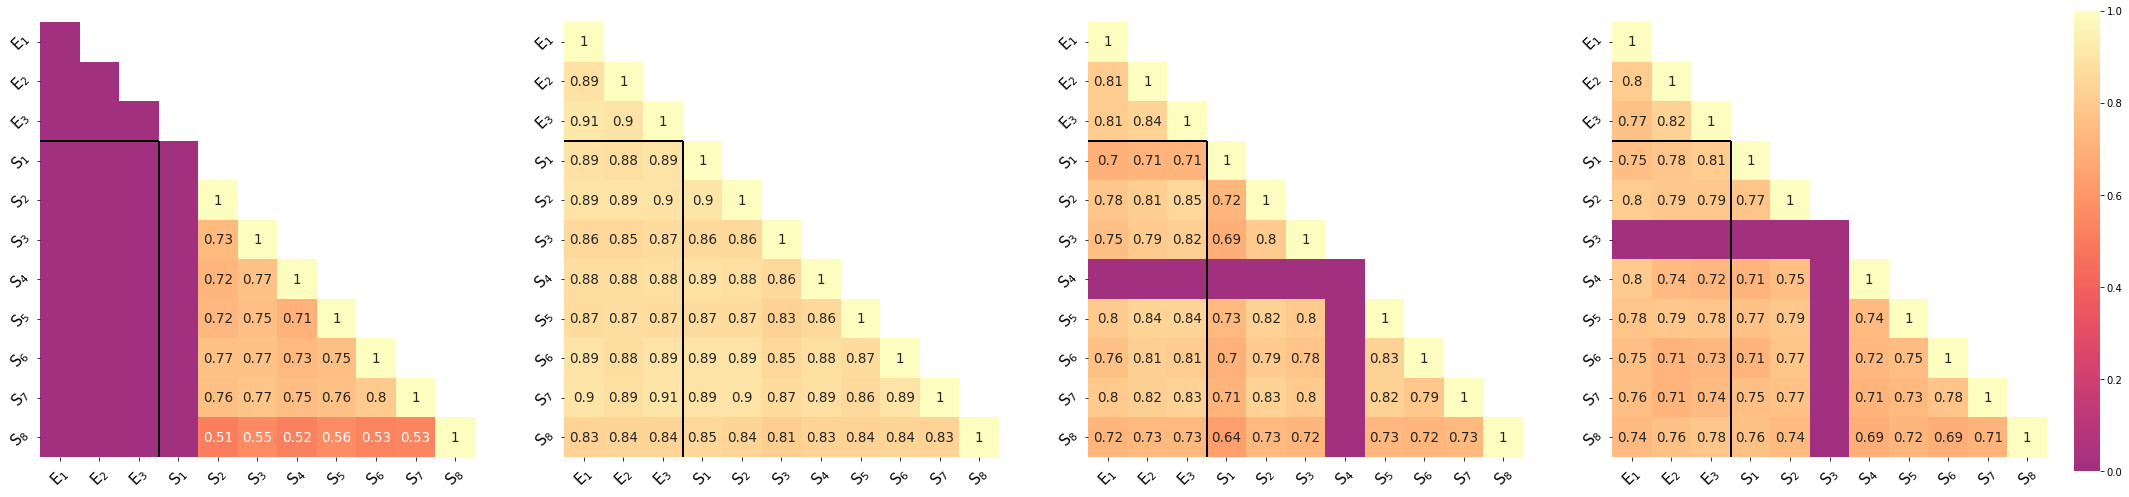

In [8]:
fig, axes = plt.subplots(1, 4, figsize=(36, 8))
cbar_ax = fig.add_axes([.91, .1, .01, .8])

for i, exp in enumerate(exps):
    kappa_heatmap(data[exp], ax=axes[i], 
                 cbar=(i == 3), 
                 cbar_ax=cbar_ax if i==3 else None)

fig.savefig(os.path.join(path_to_res, 'kappa.pdf'), bbox_inches='tight', transparent=True)